In this notebook we will use the BindingDB database to download the data from a pharmaceutical patent and analyze that data. We will perform the following steps. 
1. Connect to Binding DB
2. Search BindingDB for a Patent
3. Download Structures Asssociated with a Patent
4. Explore the Data Associated with the Patent Structures
5. Group the Dataset By Bemis-Murcko Scaffolds
6. Associate Activity Distributions with the Scaffolds
7. Examine Molecules with the Same Scaffold

### 1. Connect to Binding DB
We will begin by opening the BindingDB website at https://www.bindingdb.org. To download files we'll need to login to BindingDB.  We can do this by clicking on the MyBindingDB link on the left side of the page. 


<img src="binding_db_login_1.png" alt="Drawing" width=150/>  

Clicking on that link will take you to the BindingDB login page.  Enter your BindingDB username and password in the corresponding boxes and press the "Go" button.  If you don't have a BindingDB account, you can click on the "Register" link to the right of the "Go" button.  If you've forgotten your password, you can use the "Reset Password" link.   


<img src="binding_db_login_2.png" alt="Drawing" width=600/>

### 2. Search BindingDB for a Patent

Binding DB containings curated records for some United States (US) and European (WO) patents. To search for a US patent, first select "Publication", then "US Patents"

<img src="binding_db_patent_1.png" alt="Drawing" width="150"/>

This will bring you to a page where you can browse recently curated patents and search by paent number. 

<img src="binding_db_patent_2.png" alt="Drawing" width=800/>

### 3. Download Structures Asssociated with a Patent

Put **US20240109915** into the search box and press "Search". 

After a few seconds you'll see this page that allows you to browse the results. We want to download the results as an SD file.  First click on "Select All Pages", then click on "Make Dataset". 

<img src="binding_db_patent_search_1.png" alt="Drawing" width=800/>

This will take you to another page that enables downloads. The default "2D SDfile" is what we want, so just click on "Go". You may have to enter your login credentials again. 

<img src="binding_db_patent_download.png" alt="Drawing" width=800/>

BidingDB will download a file with a long random name.  In my case the file was named 35A6EC1A3C9266A38807F72D62C1E3FBki.sdf.

### 4. Explore the Data Associated with the Patent Structures
After the download we have an SD file with 102 structures.  We'd like to get a better ideas of the realiationships between chemical structure and biological activity in the patent dataset.  Now we'll use a bit of Python code to understandt the data. 

We begin by importing the necessary Python libraries. 

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
import numpy as np
import useful_rdkit_utils as uru
import mols2grid
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import io
import base64
from IPython.display import HTML
import seaborn as sns
import matplotlib.pyplot as plt

We'll read the SD file downloaded from BindingDB. For simplicity, I specified this as a url to the file I donnloaded. You can change the filename variable in the cell below to use your own SD file.

In [2]:
filename = "35A6EC1A3C9266A38807F72D62C1E3FBki.sdf"
df = PandasTools.LoadSDF(filename)

There is a lot of information in the SD file.  Let's look at the data fields in the SD file. 

In [3]:
df.columns

Index(['From', 'BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand InChI Key',
       'BindingDB MonomerID', 'BindingDB Ligand Name', 'Target Name',
       'Target Source Organism According to Curator or DataSource', 'Ki (nM)',
       'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)',
       'pH', 'Temp C', 'Curation/DataSource', 'Article DOI',
       'BindingDB Entry DOI', 'PMID', 'PubChem AID', 'Patent Number',
       'Authors', 'Institution', 'Link to Ligand in BindingDB',
       'Link to Ligand-Target Pair in BindingDB', 'Ligand HET ID in PDB',
       'PDB ID(s) for Ligand-Target Complex', 'PubChem CID', 'PubChem SID',
       'ChEBI ID of Ligand', 'ChEMBL ID of Ligand', 'DrugBank ID of Ligand',
       'IUPHAR_GRAC ID of Ligand', 'KEGG ID of Ligand', 'ZINC ID of Ligand',
       'Number of Protein Chains in Target (bigger than 1 implies a multichain complex)',
       'BindingDB Target Chain Sequence', 'PDB ID(s) of Target Chain',
       'UniProt (SwissProt) Recommen

There are 4 fields that could potentially hold biological data. 

In [4]:
activity_cols = ['Ki (nM)','IC50 (nM)', 'Kd (nM)', 'EC50 (nM)']

Let's see how many of these fields actually contain data.  Note that the olnly populated field is "IC50 (nM)" which has 102 records.  Recall that the 102 structures were curated from the patent. 

In [5]:
df[activity_cols].replace('', np.nan).count()

Ki (nM)        0
IC50 (nM)    102
Kd (nM)        0
EC50 (nM)      0
dtype: int64

Let's look at the IC50 values.  Note that these values currently stored as text strings.  This isn't very useful if we want to do any sort of analysis.  We'll fix this below. 

In [6]:
df["IC50 (nM)"].values

array([' 0.900', ' 1.30', ' 1.30', ' 1.50', ' 1.80', ' 2.20', ' 2.40',
       ' 2.40', ' 2.60', ' 3.10', ' 3.10', ' 3.10', ' 3.20', ' 3.40',
       ' 3.50', ' 3.50', ' 3.60', ' 3.60', ' 3.90', ' 3.90', ' 4.00',
       ' 4.10', ' 4.40', ' 4.50', ' 4.60', ' 4.60', ' 4.90', ' 5.10',
       ' 5.20', ' 5.20', ' 5.30', ' 5.40', ' 5.40', ' 5.50', ' 5.60',
       ' 5.80', ' 6.10', ' 6.20', ' 6.20', ' 6.30', ' 6.40', ' 6.40',
       ' 6.60', ' 6.70', ' 7.00', ' 7.10', ' 7.20', ' 7.20', ' 7.30',
       ' 7.60', ' 7.60', ' 7.90', ' 8.00', ' 8.60', ' 9.40', ' 9.60',
       ' 9.60', ' 9.90', ' 10.00', ' 10.1', ' 10.6', ' 11.0', ' 11.1',
       ' 11.1', ' 11.7', ' 11.8', ' 12.3', ' 12.9', ' 13.0', ' 13.4',
       ' 13.6', ' 14.0', ' 14.3', ' 15.0', ' 15.3', ' 16.1', ' 17.6',
       ' 17.9', ' 18.1', ' 19.5', ' 19.7', ' 19.7', ' 22.4', ' 22.9',
       ' 23.2', ' 23.2', ' 23.3', ' 26.1', ' 27.3', ' 29.5', ' 30.1',
       ' 33.6', ' 45.5', ' 46.5', ' 65.4', ' 85.9', ' 92.6', ' 109',
       ' 115', ' 18

We will change the datatype of of the IC50 field from **object**, which is essentailly a text string, to **float**.

In [7]:
df["IC50 (nM)"] = df["IC50 (nM)"].astype(float)

We would like to understand the distribution of activity values in the patent.  To do this we can plot a distribution histogram using the [displot](https://seaborn.pydata.org/generated/seaborn.displot.html) function in Pandas. Note that the plot below isn't very helpful.  The IC50 values range from 0.9 to 10,000 nM, this is a huge range that doesn't lend itself well to a plot. 

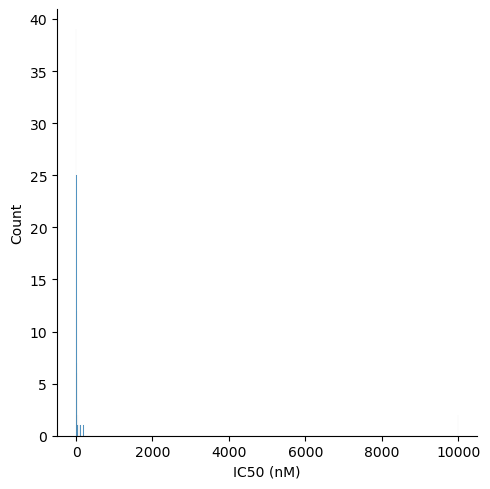

In [8]:
sns.displot(df["IC50 (nM)"])

A more useful approach is to examine the distribution on a log scale.  Let's create a new column in the dataframe with the negative log the IC50 as the pIC50. 

In [9]:
df['pIC50'] = -np.log10(df["IC50 (nM)"] * 1e-9)

The plot below looks a lot better and shows the activity distibution. 

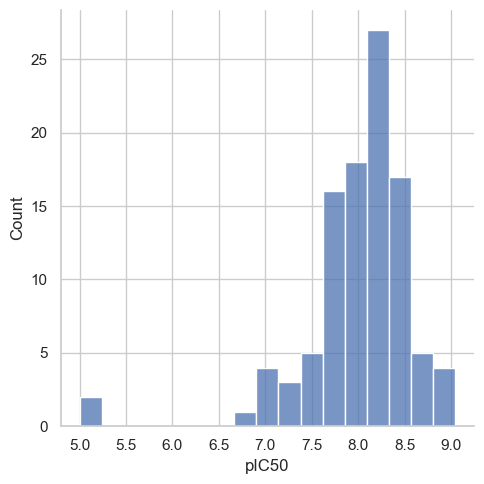

In [10]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.displot(df.pIC50);

### 5. Group the Dataset By Bemis-Murcko Scaffolds

To get a quick overview of the structures in the patent, we can reduce the structures to [Bemis-Murcko scaffolds](https://rdkit.org/docs/source/rdkit.Chem.Scaffolds.MurckoScaffold.html). 

In [11]:
df['SMILES'] = df.ROMol.apply(Chem.MolToSmiles)
df['scaffold_smi'] = df.SMILES.apply(Chem.Scaffolds.MurckoScaffold.MurckoScaffoldSmiles)

Create a new dataframe with the unique Bemis Murcko scaffolds and the number of molecules with tha scaaffold in the initial dataset. 

In [12]:
scaffold_df = uru.value_counts_df(df,"scaffold_smi")
scaffold_df['mol'] = scaffold_df.scaffold_smi.apply(Chem.MolFromSmiles)
[rdDepictor.Compute2DCoords(m) for m in scaffold_df.mol]
scaffold_df.head()

,scaffold_smi,count,mol
0,O=C1CC2(CCN(C(=O)c3ccc4[nH]ncc4c3)CC2)Cc2scnc21,13,<rdkit.Chem.rdchem.Mol object at 0x16bb04040>
1,O=C1CC2(CCN(C(=O)c3ccc4ncccc4c3)CC2)Cc2scnc21,13,<rdkit.Chem.rdchem.Mol object at 0x16bb047b0>
2,O=C1CC2(CCN(C(=O)c3ccc4[nH]ccc4c3)CC2)Cc2scnc21,9,<rdkit.Chem.rdchem.Mol object at 0x16bb04510>
3,O=C1CC2(CCN(C(=O)c3ccc4cc[nH]c4c3)CC2)Cc2scnc21,8,<rdkit.Chem.rdchem.Mol object at 0x16bb042e0>
4,O=C1CC2(CCN(C(=O)c3ccc4ccccc4c3)CC2)Cc2scnc21,8,<rdkit.Chem.rdchem.Mol object at 0x16bb04430>


Plot the scaffold distribution as a histogram.

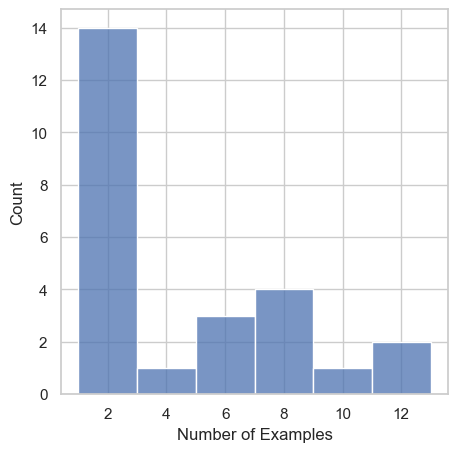

In [13]:
sns.set(rc={'figure.figsize': (5, 5)})
sns.set_style('whitegrid')
ax = sns.histplot(scaffold_df["count"])
ax.axes.set_xlabel("Number of Examples")
ax.set_ylabel("Count");

### 6. Associate Activity Distributions with the Scaffolds

It's useful to examine the activity distributions associated with each of the scaffolds.  To do this, we'll display a table with the scaffold, the number of molecules with that scaffold, and a box plot showing the associated activity distributions. To do this, we will define a couple of support functions. 

In [14]:
def boxplot_base64_image(dist):
    """
    Plot a distribution as a seaborn boxplot and save the resulting image as a base64 image. 
    """
    sns.set(rc={'figure.figsize': (3, 1)})
    sns.set_style('whitegrid')
    ax = sns.boxplot(x=dist)
    ax.set_xlim(0,10)
    s = io.BytesIO()
    plt.savefig(s, format='png', bbox_inches="tight")
    plt.close()
    s = base64.b64encode(s.getvalue()).decode("utf-8").replace("\n", "")
    return '<img align="left" src="data:image/png;base64,%s">' % s

def mol_to_base64_image(mol):
    """
    Convert an RDKit molecule to an image
    """
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 150)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    bio = io.BytesIO()
    text = drawer.GetDrawingText()
    im_text64 = base64.b64encode(text).decode('utf8')
    img_str = f"<img src='data:image/png;base64, {im_text64}'/>"
    return img_str

With the functions above we can define this table with a few lines of code. One could argue that I should have labeled the x-axis on the boxplots below.  However, I feel that adds a lot of excess visual noise. 


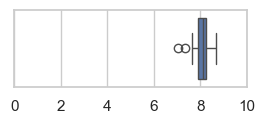
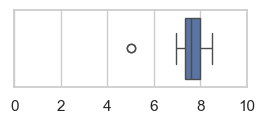
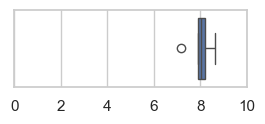
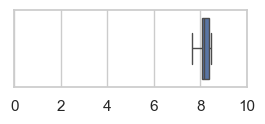
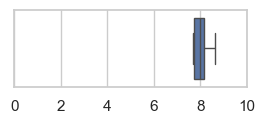
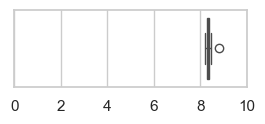
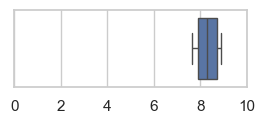
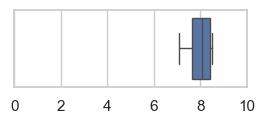
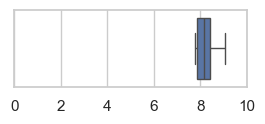
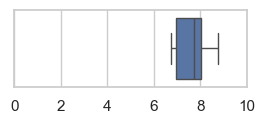

In [15]:
rows_to_display = 10
tmp_df = scaffold_df.head(rows_to_display).copy()
tmp_df['mol_img'] = tmp_df.mol.apply(mol_to_base64_image)
img_list = []
for smi in tmp_df.scaffold_smi:
    img_list.append(boxplot_base64_image(df.query("scaffold_smi == @smi").pIC50.values))
tmp_df['dist_img'] = img_list
HTML(tmp_df[['mol_img','count','dist_img']].to_html(escape=False))

### 7. Examine Molecules with the Same Scaffold
After looking the figure above, we may want to perform a more detailed analysis of the molecules in each of the scaffold groups above. By changing the **scaffold_id** field below we can view different sets of molecules with the same scaffold. The data is sorted by **IC50 (nM)"**.  To faicilitate SAR analysis we've alighed the structures to the scaffolds in table ablove. 

In [21]:
scaffold_id = 1
scaffold_smi = scaffold_df.scaffold_smi.values[scaffold_id]
tmp_df = df.query("scaffold_smi == @scaffold_smi").copy()
tmp_df['mol'] = tmp_df.SMILES.apply(Chem.MolFromSmiles)
scaffold_mol = scaffold_df.mol.values[scaffold_id]
AllChem.Compute2DCoords(scaffold_mol)
[AllChem.GenerateDepictionMatching2DStructure(m,scaffold_mol) for m in tmp_df.mol]
mols2grid.display(tmp_df.sort_values("IC50 (nM)"),size=(175,175),subset=["img","IC50 (nM)"], mol_col="mol",
                  use_coords=True, prerender=True)

MolGridWidget()